# Feauture Selection with Clustered Principle Components

This is a feature selection algorithm based on hierarchically clustered partitions. The goal is to create partitions of variables such that variables within each partition are "related" to each other BUT NOT to variables in other partitions. Then, principle component analysis is used to extract a subset of features that explain the most variance within each partition. The total list of predictive variables are our selected features.

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import torch.nn as nn
import torch
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster

In [2]:
df = pd.read_excel(r"C:\Users\joshu\Downloads\labs_complete.xlsx", index_col = "subject_id")
df.columns = df.columns.str.replace("_percentile", "")
df

,51221,51265,50912,50971,51222,51301,51249,51279,51250,51248,...,50813,50863,50885,50820,50862,50802,50821,50804,50818,50910
subject_id,,,,,,,,,,,,,,,,,,,,,
12138413,0.653935,0.471492,0.668170,0.122564,0.585660,0.379092,0.273604,0.508236,0.829349,0.653375,...,0.328330,0.188457,0.750168,0.371901,0.539988,0.660286,0.141536,0.662118,0.722870,0.642922
12988457,0.744261,0.549488,0.764983,0.873920,0.600321,0.128942,0.115307,0.782644,0.367417,0.135998,...,0.557945,0.414605,0.663706,0.807163,0.603970,0.469087,0.234647,0.287035,0.146159,0.226079
18624683,0.074887,0.071672,0.197234,0.012156,0.120607,0.564170,0.834371,0.080755,0.603556,0.757634,...,0.875884,0.103988,0.750168,0.485908,0.374253,0.273487,0.058992,0.287035,0.304645,0.898581
11914968,0.870576,0.616041,0.668170,0.122564,0.921972,0.945371,0.875151,0.799719,0.661008,0.850342,...,0.974600,0.565034,0.396615,0.154482,0.770091,0.108031,0.535329,0.117103,0.471935,0.878056
17957742,0.433584,0.264405,0.563640,0.886779,0.430006,0.735389,0.424468,0.512455,0.306750,0.246183,...,0.119353,0.475349,0.780999,0.872643,0.425130,0.660286,0.916355,0.436496,0.173674,0.886206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10581271,0.851529,0.936860,0.197234,0.911493,0.799458,0.880900,0.358276,0.885898,0.306750,0.246183,...,0.735748,0.723036,0.841488,0.807163,0.660628,0.660286,0.538191,0.436496,0.234206,0.343193
13724012,0.100652,0.692532,0.834837,0.921640,0.083049,0.620707,0.148654,0.129871,0.423765,0.188027,...,0.977775,0.987380,0.959450,0.442467,0.323569,0.187239,0.042263,0.186881,0.200969,0.492001
17427308,0.588070,0.970488,0.895270,0.900040,0.460534,0.883511,0.104058,0.383889,0.921153,0.653375,...,0.875884,0.788995,0.841488,0.335876,0.374253,0.273487,0.009905,0.436496,0.615012,0.780260


In [3]:
labs = {
    "51221": "Hematocrit",
    "51265": "Platelet Count",
    "50912": "Creatinine",
    "50971": "Potassium",
    "51222": "Hemoglobin",
    "51301": "White Blood Cells",
    "51249": "MCHC",
    "51279": "Red Blood Cells",
    "51250": "MCV",
    "51248": "MCH",
    "51277": "RDW",
    "51006": "Urea Nitrogen",
    "50983": "Sodium",
    "50902": "Chloride",
    "50882": "Bicarbonate",
    "50868": "Anion Gap",
    "50931": "Glucose",
    "50960": "Magnesium",
    "50893": "Calcium, Total",
    "50970": "Phosphate",
    "51237": "INR(PT)",
    "51274": "PT",
    "51275": "PTT",
    "51146": "Basophils",
    "51256": "Neutrophils",
    "51254": "Monocytes",
    "51200": "Eosinophils",
    "51244": "Lymphocytes",
    "52172": "RDW-SD",
    "50934": "H",
    "51678": "L",
    "50947": "I",
    "50861": "Alanine Aminotransferase (ALT)",
    "50878": "Asparate Aminotransferase (AST)",
    "50813": "Lactate",
    "50863": "Alkaline Phosphatase",
    "50885": "Bilirubin, Total",
    "50820": "pH",
    "50862": "Albumin",
    "50802": "Base Excess",
    "50821": "pO2",
    "50804": "Calculated Total CO2",
    "50818": "pCO2",
    "52075": "Absolute Neutrophil Count",
    "52073": "Absolute Eosinophil Count",
    "52074": "Absolute Monocyte Count",
    "52069": "Absolute Basophil Count",
    "51133": "Absolute Lymphocyte Count",
    "50910": "Creatine Kinase (CK)",
    "52135": "Immature Granulocytes"
}
labs_reversed = {value: key for key, value in labs.items()}

In [4]:
encode = lambda x: [labs_reversed[i] for i in x]
decode = lambda x: [labs[i] for i in x]

In [28]:
calculated = ["MCHC", "MCV", "MCH", "RDW", "RDW-SD", "Base Excess", "Calculated Total CO2","Anion Gap","INR(PT)"]
include = list(set(df.columns.to_list())-set(calculated))
df = df[include]

### Cluster variables into partitions of highly related variables

In [29]:
Z = linkage(df.corr(), method="ward")

In [30]:
corr_matrix = df.corr().values

distance_matrix = 1 - np.abs(corr_matrix)

condensed_dist = squareform(distance_matrix)

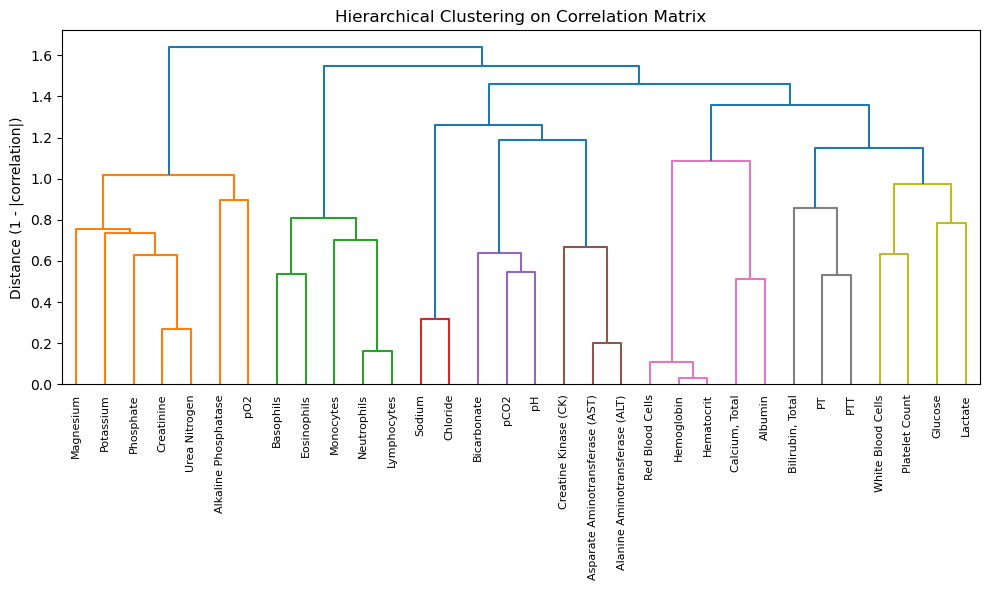

In [31]:
Z = linkage(condensed_dist, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df.columns, orientation='top', leaf_rotation=90)
plt.title('Hierarchical Clustering on Correlation Matrix')
plt.ylabel('Distance (1 - |correlation|)')
plt.tight_layout()
plt.show()

In [48]:
distance_threshold = 1.0  # Adjust based on your dendrogram
clusters = fcluster(Z, t=distance_threshold, criterion='distance')

# Create dictionary of variables in each cluster
cluster_dict = {}
for i, cluster_id in enumerate(clusters):
    var_name = df.columns[i]
    if cluster_id not in cluster_dict:
        cluster_dict[cluster_id] = []
    cluster_dict[cluster_id].append(var_name)

# Print the cluster dictionary
print("Variables in each cluster:")
for cluster_id, variables in cluster_dict.items():
    print(f"Cluster {cluster_id}: {variables}")

Variables in each cluster:
Cluster 10: ['White Blood Cells', 'Glucose', 'Platelet Count', 'Lactate']
Cluster 4: ['Sodium', 'Chloride']
Cluster 2: ['Alkaline Phosphatase', 'pO2']
Cluster 3: ['Monocytes', 'Neutrophils', 'Basophils', 'Eosinophils', 'Lymphocytes']
Cluster 5: ['pCO2', 'pH', 'Bicarbonate']
Cluster 7: ['Hemoglobin', 'Red Blood Cells', 'Hematocrit']
Cluster 8: ['Calcium, Total', 'Albumin']
Cluster 6: ['Asparate Aminotransferase (AST)', 'Alanine Aminotransferase (ALT)', 'Creatine Kinase (CK)']
Cluster 1: ['Phosphate', 'Creatinine', 'Potassium', 'Urea Nitrogen', 'Magnesium']
Cluster 9: ['Bilirubin, Total', 'PT', 'PTT']


### Extract variables that contribute most to principle component 1

In [53]:
var_list = []
for cluster_id, variables in cluster_dict.items():
    
    df_sub=df[variables]
    pca = PCA()
    pca.fit(df_sub)

    # Get absolute loadings for PC1 (which explains most variance)
    loadings = pd.DataFrame(
        pca.components_.T * np.sqrt(pca.explained_variance_),
        columns=[f'PC{i}' for i in range(1, len(df_sub.columns)+1)],
        index=df_sub.columns
    )

    # Find variables with highest absolute loadings on PC1
    num_vars = len(variables)//2
    top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(5)
    selected = loadings['PC1'].abs().sort_values(ascending=False).head(num_vars)
    var_list = var_list + selected.index.to_list()
    print("\nTop variables contributing to PC1:")
    print(top_pc1)
    print("\nSelected Variables:")
    print(selected)


Top variables contributing to PC1:
White Blood Cells    0.206289
Glucose              0.196494
Platelet Count       0.179958
Lactate              0.157005
Name: PC1, dtype: float64

Selected Variables:
White Blood Cells    0.206289
Glucose              0.196494
Name: PC1, dtype: float64

Top variables contributing to PC1:
Sodium      0.293793
Chloride    0.285546
Name: PC1, dtype: float64

Selected Variables:
Sodium    0.293793
Name: PC1, dtype: float64

Top variables contributing to PC1:
Alkaline Phosphatase    0.255198
pO2                     0.148014
Name: PC1, dtype: float64

Selected Variables:
Alkaline Phosphatase    0.255198
Name: PC1, dtype: float64

Top variables contributing to PC1:
Neutrophils    0.240070
Lymphocytes    0.230074
Monocytes      0.204839
Basophils      0.166977
Eosinophils    0.165321
Name: PC1, dtype: float64

Selected Variables:
Neutrophils    0.240070
Lymphocytes    0.230074
Name: PC1, dtype: float64

Top variables contributing to PC1:
pCO2           0.303

##### Final list of selected features

In [54]:
var_list

['White Blood Cells',
 'Glucose',
 'Sodium',
 'Alkaline Phosphatase',
 'Neutrophils',
 'Lymphocytes',
 'pCO2',
 'Hematocrit',
 'Calcium, Total',
 'Alanine Aminotransferase (ALT)',
 'Phosphate',
 'Urea Nitrogen',
 'PTT']